In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import DBSCAN, KMeans
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set()

## Loading Dataset and Checking

In [3]:
df = pd.read_csv('../datasets/cleaned_agg_train_wx.csv')

In [4]:
pd.set_option('display.max_columns', 100)
df.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,NumMosquitos,WnvPresent,Sunrise,Sunset,CodeSum,ResultDir,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,1,0,0421,1917,BR HZ,18,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.0,0.059667,29.361333,30.085,8.646667,10.363333
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,1,0,0421,1917,BR HZ,18,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.0,0.059667,29.361333,30.085,8.646667,10.363333


In [5]:
df.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
Station                   0
NumMosquitos              0
WnvPresent                0
Sunrise                   0
Sunset                    0
CodeSum                   0
ResultDir                 0
Tmax                      0
Tmin                      0
Tavg                      0
Depart                    0
DewPoint                  0
WetBulb                   0
Heat                      0
Cool                      0
SnowFall                  0
PrecipTotal               0
StnPressure               0
SeaLevel                  0
ResultSpeed               0
AvgSpeed                  0
dtype: int64

In [6]:
df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
Station                     int64
NumMosquitos                int64
WnvPresent                  int64
Sunrise                    object
Sunset                     object
CodeSum                    object
ResultDir                   int64
Tmax                      float64
Tmin                      float64
Tavg                      float64
Depart                    float64
DewPoint                  float64
WetBulb                   float64
Heat                      float64
Cool                      float64
SnowFall                  float64
PrecipTotal               float64
StnPressure               float64
SeaLevel                  float64
ResultSpeed   

In [7]:
df[df['SnowFall'] != 0]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,NumMosquitos,WnvPresent,Sunrise,Sunset,CodeSum,ResultDir,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed


Noticed that _Snowfall_ feature is all 0. We will drop it subsequently

### Inserting a new feature 'Month' to help us visualize relationships later on

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = [i.month for i in df['Date']]

In [9]:
df.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,NumMosquitos,WnvPresent,Sunrise,Sunset,CodeSum,ResultDir,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Month
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,1,0,0421,1917,BR HZ,18,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.0,0.059667,29.361333,30.085,8.646667,10.363333,5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,1,0,0421,1917,BR HZ,18,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.0,0.059667,29.361333,30.085,8.646667,10.363333,5


## Exploratory Data Analysis

Previously when using the **daily** weather data, there seem to be no relations or pattern between the presence of WnV & temperatures, precipitation & windspeeds.

We thought about it and intuitively it does not make sense to take daily weather readings for the model (daily changes in weather temperature, etc should not have an immediate impact on the number of mosquitoes and hence the presence of the WnV). As such we created a **rolling average of 30 days** for each numerical feature of each station (done in the cleaning of weather data).

In [10]:
# Creating functions to help us plot graphs later on

def pplot(df, feature1, feature2):
    frame = df[[feature1, feature2]]
    sns.pairplot(frame)
    
    
def plot_value(df, feature_name):
    """Defining function to help us plot resampled monthly mean (downsampling) charts later on"""
    train_years = ['2007', '2009', '2011', '2013']
    fg, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)
    plot_df = df.set_index('Date')
    fg.tight_layout(pad=7.0)
    ax=ax.flatten();
    
    for i in range(len(train_years)):
        ax[i].plot(plot_df.loc[train_years[i]][feature_name].resample('M').mean())
        ax[i].set_title('Plot of resampled monthly mean of ' + feature_name + ' over ' + train_years[i])
        ax[i].tick_params(labelrotation=90)
        ax[i].set_ylabel(feature_name + ' mean')
        
        
def plot_value_yronyr_sum(df, feature_name):
    """Defining function to help us plot resampled annual mean (downsampling) later on"""
    df_plot = df.set_index('Date')
    yr2007 = df_plot.loc['2007'][feature_name].resample('A').sum()['2007-12-31'] # The last date selection returns the value, if not it will be the 'dataframe'
    yr2009 = df_plot.loc['2009'][feature_name].resample('A').sum()['2009-12-31']
    yr2011 = df_plot.loc['2011'][feature_name].resample('A').sum()['2011-12-31']
    yr2013 = df_plot.loc['2013'][feature_name].resample('A').sum()['2013-12-31']
    
    x = np.arange(4).tolist()
    yrchange = [yr2007, yr2009, yr2011, yr2013]
    
    plt.figure(figsize=(8,5))
    plt.bar(x, yrchange)
    plt.title('Plot of resampled yearly sum of ' + feature_name)
    plt.xticks(x, ['2007', '2009', '2011', '2013'])
    plt.xlabel('Year')
    plt.ylabel(feature_name + ' sum');

In [11]:
# Pairplot for only wx data
plot_wx_df = df[['WnvPresent', 'Station', 'NumMosquitos', 'Sunrise', 'Sunset',
       'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed']]

In [12]:
# sns.pairplot(plot_wx_df);

### Taking a closer look at the relations between Month feature and target

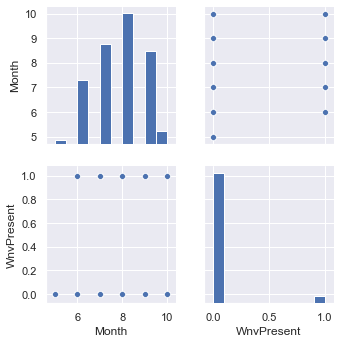

In [13]:
pplot(df, 'Month', 'WnvPresent')

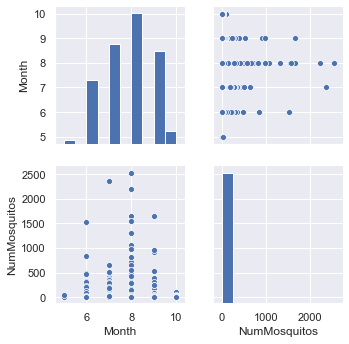

In [14]:
pplot(df, 'Month', 'NumMosquitos')

---
Wnv is only present from June to October which coincides with the increase in No. of Mosquitoes recorded by the traps.

---

### Taking a closer look at the relations between Temperature features and target

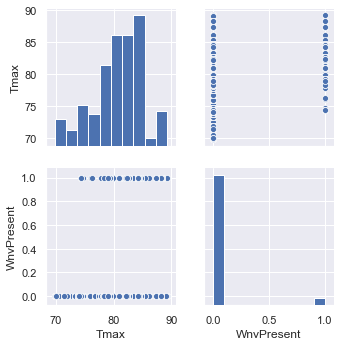

In [15]:
pplot(df, 'Tmax', 'WnvPresent')

---
Higher temperatures -> Higher chance of WnvPresence

---

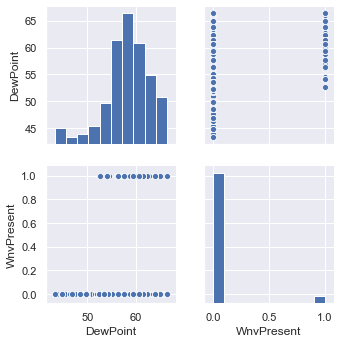

In [16]:
pplot(df, 'DewPoint', 'WnvPresent')

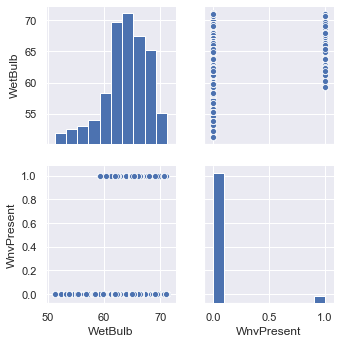

In [17]:
pplot(df, 'WetBulb', 'WnvPresent')

---
Seems to me that at low wetbulb temperature, there is no presence of WnV as well.

---

### Taking a closer look at the relations between NumMosquitos feature and target

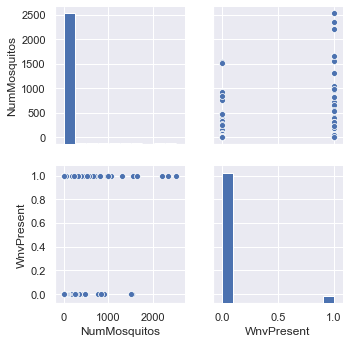

In [18]:
pplot(df, 'NumMosquitos', 'WnvPresent')

In [19]:
# Checking the species which have mosquito counts above 1000

df[df['NumMosquitos'] > 1000]['Species'].unique()

array(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS'], dtype=object)

In [20]:
# Checking the number of instances of presence of WnV for mosquito counts above 1000

df[df['NumMosquitos'] > 1000]['WnvPresent'].sum()

8

---
Based on the graphs above, it seems that above a certain count of mosquitos (approx 1500), the presence of WnV is almost garuanteed.

Also, only 2 species _(CULEX PIPIENS & CULEX PIPIENS/RESTUANS)_ of mosquitos ever exceeded the count of 1000. Might be worth focusing on the control of these 2 species in the future.

---

**Using ANOVA to see if the means between the presence of WnvPresent for number of mosquitos differs statistically**

In [21]:
f_classif(df[['NumMosquitos']], df['WnvPresent']) # Alr done above

(array([488.75013036]), array([2.43262316e-105]))

As we can see, the p value is 0.00000025<0.05 which means that we reject the null hypothesis that the mean of No. of Mosquitos is statistically the same for both the groups of 1 & 0 in WnvPresent.

### Visualizing NumMosquitos feature over Month

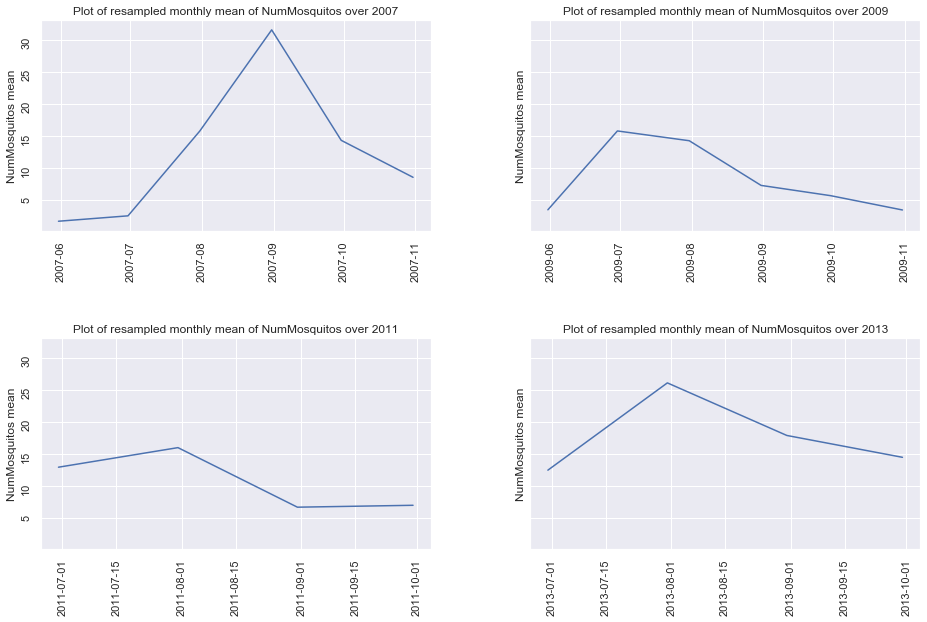

In [22]:
plot_value(df, 'NumMosquitos');

---
Notice how the number of mosquitos usually picks up in July and start decreasing after September/October. Perhaps there is some sort of monthly seasonality when it comes to the mosquito counts.

---

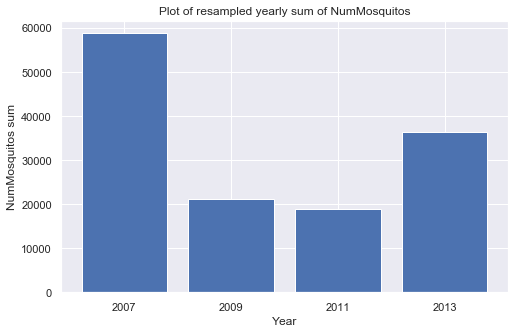

In [25]:
plot_value_yronyr_sum(df, 'NumMosquitos')

Notice that there is quite a drastic difference between the years 2009, 2011 & 2007, 2013.

Possible reasons would include:
1. Something drastic happened from 2007 to 2009 _(personally i feel this is unlikely as there is an increase towards 2013 again)_
2. There might be some kind of annual seasonality when it comes to number of mosquitoes

### Taking a closer look at the Species

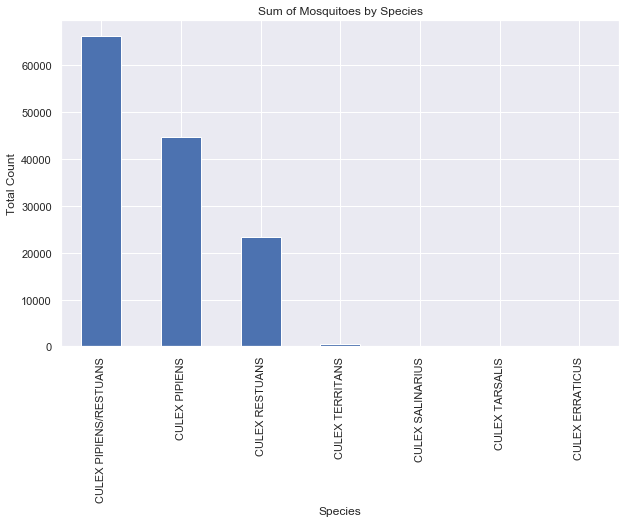

In [26]:
plt.figure(figsize=(10,6))
df.groupby('Species')['NumMosquitos'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Sum of Mosquitoes by Species')
plt.ylabel('Total Count')
plt.xlabel('Species');

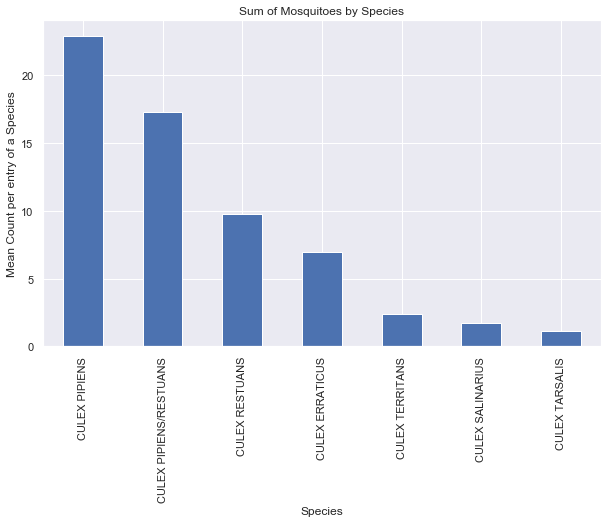

In [27]:
plt.figure(figsize=(10,6))
df.groupby('Species')['NumMosquitos'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Sum of Mosquitoes by Species')
plt.ylabel('Mean Count per entry of a Species')
plt.xlabel('Species');

From the initial total count plot, it looks as tho there is no count of the Species other than CULEX PIPIENS/RESTUANS, CULEX PIPIENS, CULEX RESTUANS & CULEX TERRITANS. However when we plot the mean count per entry for the Species, we see that there are infact the presence of other species than the 3 with highest count.

In [28]:
pd.DataFrame(df.groupby('Species')['WnvPresent'].sum().sort_values(ascending=False))

,WnvPresent
Species,
CULEX PIPIENS/RESTUANS,225
CULEX PIPIENS,184
CULEX RESTUANS,48
CULEX TERRITANS,0
CULEX TARSALIS,0
CULEX SALINARIUS,0
CULEX ERRATICUS,0


As we see above, the presence of WnV is only seen in 3 species.

**This is a very important finding. It basically tells us that it is likely that not all species of mosquitoes found in the trap will carry the West Nile Virus**

In [29]:
wnv_present = df[['Date','Longitude', 'Latitude', 'WnvPresent']]
wnv_present = wnv_present.dropna()
wnv_present_2011_2013 = wnv_present[(wnv_present['Date'].dt.year == 2011) | (wnv_present['Date'].dt.year == 2013)]
df_2011_2013 = df[(df['Date'].dt.year == 2011) | (df['Date'].dt.year == 2013)]

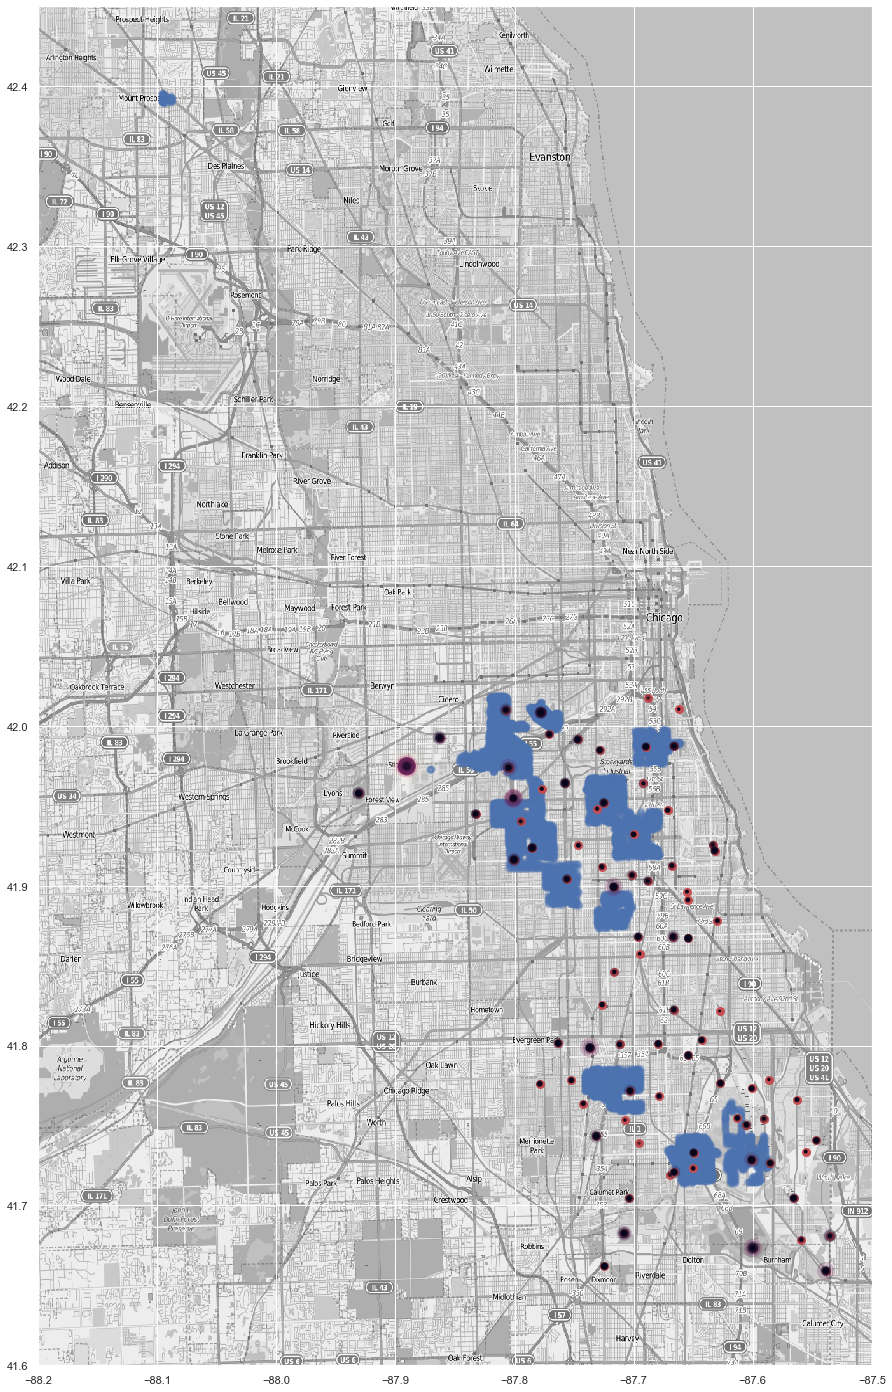

In [33]:
mapdata = np.loadtxt("../datasets/mapdata_copyright_openstreetmap_contributors.txt")
spray = pd.read_csv('../datasets/cleaned_spray.csv')
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.2, -87.5, 41.6, 42.45)

plt.figure(figsize=(20,25))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
spray_locations = spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(spray_locations[:,0], spray_locations[:,1], marker='o', linewidths=2, alpha=0.2)
locations = wnv_present_2011_2013[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='o', linewidths=3, c='r')
plt.scatter(df_2011_2013['Longitude'], df_2011_2013['Latitude'], s=df_2011_2013['NumMosquitos'], c=df_2011_2013['NumMosquitos'], alpha=0.2)

plt.savefig('map_with_wnv.png')


## Feature Engineering

### Attempting Clustering to help label locations

**Note:** _The traps between the train & test set do not overlap completely. As such we have decided to use kmeans clustering to group the traps into clusters based on the proximity of their geographical location (Longitude & Latitude)._

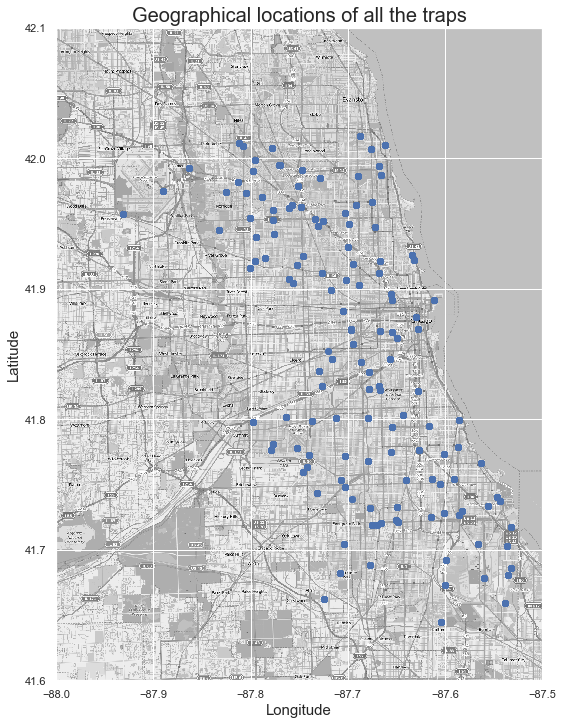

In [52]:
# Visualizing the location of all the training traps

plt.figure(figsize=(15,12))
lon_lat_box2 = (-88, -87.5, 41.6, 42.1)

plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box2, 
           aspect=aspect)

plt.scatter(df['Longitude'], df['Latitude'])
plt.title('Geographical locations of all the traps', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15);

In [43]:
km = KMeans(n_clusters=100)

In [44]:
df[['Longitude', 'Latitude']].head()

,Longitude,Latitude
0,-87.800991,41.954690
1,-87.800991,41.954690
2,-87.769279,41.994991
3,-87.824812,41.974089
4,-87.824812,41.974089


In [45]:
cluster_km = km.fit(df[['Longitude', 'Latitude']])

In [46]:
df['Cluster'] = cluster_km.predict(df[['Longitude', 'Latitude']])

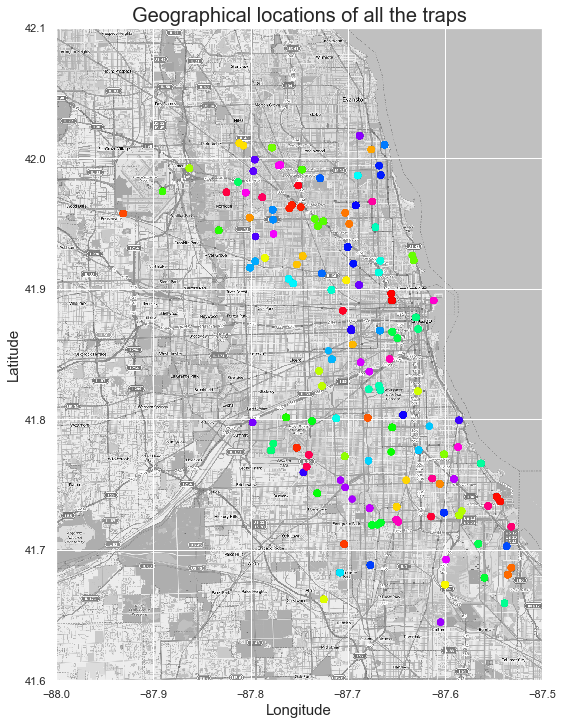

In [51]:
# Visualizing the final clusters

plt.figure(figsize=(15,12))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box2, 
           aspect=aspect)
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='hsv')
plt.title('Geographical locations of all the traps', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15);

**Implementing clustering to kaggle set and exporting for later use**

In [53]:
kaggle = pd.read_csv('../datasets/cleaned_agg_test_wx.csv')

In [54]:
kaggle['Cluster'] = cluster_km.predict(kaggle[['Longitude', 'Latitude']]) # Clustering locations for input

In [55]:
kaggle.head()

,Date,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,Sunrise,Sunset,CodeSum,ResultDir,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Cluster
0,2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0416,1926,,18,71.8,50.8,61.566667,-1.033333,48.9,55.2,5.966667,2.533333,0.0,0.125333,29.156,29.875667,8.513333,10.33,10
1,2008-06-11,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0416,1926,,18,71.8,50.8,61.566667,-1.033333,48.9,55.2,5.966667,2.533333,0.0,0.125333,29.156,29.875667,8.513333,10.33,10
2,2008-06-11,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0416,1926,,18,71.8,50.8,61.566667,-1.033333,48.9,55.2,5.966667,2.533333,0.0,0.125333,29.156,29.875667,8.513333,10.33,10
3,2008-06-11,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0416,1926,,18,71.8,50.8,61.566667,-1.033333,48.9,55.2,5.966667,2.533333,0.0,0.125333,29.156,29.875667,8.513333,10.33,10
4,2008-06-11,5,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0416,1926,,18,71.8,50.8,61.566667,-1.033333,48.9,55.2,5.966667,2.533333,0.0,0.125333,29.156,29.875667,8.513333,10.33,10


In [56]:
kaggle.to_csv('../datasets/cleaned_agg_test_wx_clustered.csv', index=False)

## Feature Elimination

---

Sunset & sunrise (timing) features are technically of the wrong dtype, however we feel that these 2 features serve no purpose in the prediction of number of mosquitoes and the presence of the WnV. If anything, the timing of sunrise & sunset should reflect on the changes in seasonality and should be captured in the time-series later on. As such we will opt to drop these 2 features.

Also, the SnowFall feature has all its data points as zero _(as shown above)_ and will thus be useless in our subsequent modeling. We will be dropping it as well.

**We shall also model without NumMosquito feature since the test set does not have it**

In [57]:
df.drop(['Sunset', 'Sunrise', 'SnowFall', 'NumMosquitos'], axis=1, inplace=True)

In [58]:
df.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,WnvPresent,CodeSum,ResultDir,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Month,Cluster
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,BR HZ,18,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,BR HZ,18,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10


---

We will also be dropping the features _Address, Station, Block, Street, AddressNumberAndStreet, AddressAccuracy & Trap_ as we feel that these would be well represented by our _Cluster_ feature.

For the purpose of this project, we will use _Month_ as a feature to capture seasonality changes and as such we will drop _Date_.

For lesser complications, we will also drop _CodeSum_.

We also felt that _ResultDir_ feature (direction of wind) is redundant for capturing the conditions for WnV and as such will drop it.

In [59]:
df.drop(['Address', 'Trap', 'Station', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Date', 'CodeSum', 'ResultDir'], axis=1, inplace=True)

In [60]:
df.head()

,Species,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Month,Cluster
0,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10
1,CULEX RESTUANS,41.954690,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10
2,CULEX RESTUANS,41.994991,-87.769279,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,84
3,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,96
4,CULEX RESTUANS,41.974089,-87.824812,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,96


**Let's use ANOVA to sieve out relevant features**

In [61]:
df.head(1)

,Species,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Month,Cluster
0,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10


In [62]:
features_anova = df.drop(['WnvPresent', 'Species', 'Month', 'Cluster'], axis=1)
target = df['WnvPresent']

In [63]:
for i in zip(features_anova.columns, f_classif(features_anova, target)[1]):
    print (i)

('Latitude', 0.004491055431949625)
('Longitude', 1.512457646691263e-12)
('Tmax', 2.425233507526377e-28)
('Tmin', 2.5242480882783046e-29)
('Tavg', 3.35017320423476e-30)
('Depart', 0.0081258838823193)
('DewPoint', 5.0568734447981606e-42)
('WetBulb', 2.3857643062980286e-39)
('Heat', 1.3939924425481454e-28)
('Cool', 5.6416566921240644e-27)
('PrecipTotal', 0.0002159955559291368)
('StnPressure', 0.0015398511481869797)
('SeaLevel', 6.075587790638565e-10)
('ResultSpeed', 8.796255153945368e-44)
('AvgSpeed', 4.464353843856836e-43)


---
All the variables above have a p-value < 0.05 and as such we will will not drop anything and proceed for now.

---

**Let's use Chi-Squared to sieve out relevant features**

In [64]:
features_chi2 = df[['Species', 'Cluster', 'Month']]
features_chi2.head()

,Species,Cluster,Month
0,CULEX PIPIENS/RESTUANS,10,5
1,CULEX RESTUANS,10,5
2,CULEX RESTUANS,84,5
3,CULEX PIPIENS/RESTUANS,96,5
4,CULEX RESTUANS,96,5


In [65]:
# Encoding variables before running chi-squared

le = LabelEncoder()
features_chi2_enc = features_chi2.copy()
features_chi2_enc['Species'] = le.fit_transform(features_chi2_enc['Species'])
# features_chi2_enc['Trap'] = le.fit_transform(features_chi2_enc['Trap'])

In [66]:
features_chi2_enc.head(2)

,Species,Cluster,Month
0,2,10,5
1,3,10,5


In [67]:
for i in zip(features_chi2.columns, chi2(features_chi2_enc, target)[1]):
    print (i)

('Species', 1.7620680844568683e-12)
('Cluster', 6.848880961374562e-08)
('Month', 0.0003153749027087854)


---
All the variables above have a p-value < 0.05 and as such we will will not drop anything and proceed for now.

---

In [68]:
# The final features which we will use to model

df.head()

,Species,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Month,Cluster
0,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10
1,CULEX RESTUANS,41.954690,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,10
2,CULEX RESTUANS,41.994991,-87.769279,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,84
3,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,96
4,CULEX RESTUANS,41.974089,-87.824812,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,5,96


## Encoding Final Features

In [69]:
# For clarity sake, we will map month as string

df['Month'] = df['Month'].map({5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct'})

In [70]:
df.head(2)

,Species,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Month,Cluster
0,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,May,10
1,CULEX RESTUANS,41.95469,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,May,10


In [71]:
df_enc = pd.get_dummies(df, columns=['Species', 'Cluster', 'Month'], drop_first=True)

In [72]:
df_enc.head(2)

,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,...,Cluster_55,Cluster_56,Cluster_57,Cluster_58,Cluster_59,Cluster_60,Cluster_61,Cluster_62,Cluster_63,Cluster_64,Cluster_65,Cluster_66,Cluster_67,Cluster_68,Cluster_69,Cluster_70,Cluster_71,Cluster_72,Cluster_73,Cluster_74,Cluster_75,Cluster_76,Cluster_77,Cluster_78,Cluster_79,Cluster_80,Cluster_81,Cluster_82,Cluster_83,Cluster_84,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Month_Jul,Month_Jun,Month_May,Month_Oct,Month_Sep
0,41.95469,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,41.95469,-87.800991,0,75.433333,51.6,63.733333,5.166667,45.266667,54.033333,3.866667,2.6,0.059667,29.361333,30.085,8.646667,10.363333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


 ## Train test splitting and Scaling Data

In [73]:
X = df_enc.drop('WnvPresent', axis=1)
y = df_enc['WnvPresent']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

In [75]:
pd.DataFrame(y_train)['WnvPresent'].value_counts(normalize=True)

0    0.946018
1    0.053982
Name: WnvPresent, dtype: float64

In [76]:
pd.DataFrame(y_test)['WnvPresent'].value_counts(normalize=True)

0    0.946313
1    0.053687
Name: WnvPresent, dtype: float64

In [77]:
ss = StandardScaler()

In [78]:
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [79]:
X_train_ss = pd.DataFrame(X_train_ss)
X_train_ss.columns = X_train.columns

X_test_ss = pd.DataFrame(X_test_ss)
X_test_ss.columns = X_test.columns

**Pickle-ing the standard scaler for use during modeling**

In [80]:
import pickle

In [81]:
pickle.dump(ss, open('../datasets/scaler.sav', 'wb'))

 ## SMOTE-ing Data
 
 _Oversampling to balance the dataset before continuing with modeling_

In [82]:
sm = SMOTE(random_state=77)

X_train_ss_resampled, y_resampled = sm.fit_resample(X_train_ss, y_train)

In [83]:
y_resampled.head()

0    0
1    0
2    0
3    0
4    0
Name: WnvPresent, dtype: int64

In [84]:
X_train_ss_resampled.head()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_55,Cluster_56,Cluster_57,Cluster_58,Cluster_59,Cluster_60,Cluster_61,Cluster_62,Cluster_63,Cluster_64,Cluster_65,Cluster_66,Cluster_67,Cluster_68,Cluster_69,Cluster_70,Cluster_71,Cluster_72,Cluster_73,Cluster_74,Cluster_75,Cluster_76,Cluster_77,Cluster_78,Cluster_79,Cluster_80,Cluster_81,Cluster_82,Cluster_83,Cluster_84,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Month_Jul,Month_Jun,Month_May,Month_Oct,Month_Sep
0,-1.560060,1.607978,-0.125656,-0.292584,-0.219797,0.596113,-0.375238,-0.275323,0.372680,-0.144807,0.209158,1.356093,1.107057,0.359673,0.647968,-0.550313,1.107520,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.104327,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,-0.570765,-0.432886,-0.097619,-0.179222,1.834596
1,-0.384376,0.615555,0.138479,0.200257,0.168248,-0.024642,0.243273,0.181998,-0.605462,-0.014161,-0.041472,-0.329313,-0.755449,1.104667,0.988078,-0.550313,-0.902918,1.597955,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.104327,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,9.935083,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,1.752035,-0.432886,-0.097619,-0.179222,-0.545079
2,1.069872,-2.800341,-2.246744,-2.454045,-2.395895,-0.486598,-1.902887,-2.172359,3.873400,-1.652257,0.698290,-1.423446,-0.466643,1.278499,1.402846,-0.550313,-0.902918,1.597955,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,9.094158,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.104327,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.0557

In [85]:
y_resampled.head()

0    0
1    0
2    0
3    0
4    0
Name: WnvPresent, dtype: int64

In [86]:
# Checking balance of SMOTE-ed dataset

y_resampled.value_counts(normalize=True)

1    0.5
0    0.5
Name: WnvPresent, dtype: float64

## Exporting the datas for later modeling

In [87]:
df_train = X_train_ss_resampled
df_train['WnvPresent'] = y_resampled

In [88]:
df_train.head()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_56,Cluster_57,Cluster_58,Cluster_59,Cluster_60,Cluster_61,Cluster_62,Cluster_63,Cluster_64,Cluster_65,Cluster_66,Cluster_67,Cluster_68,Cluster_69,Cluster_70,Cluster_71,Cluster_72,Cluster_73,Cluster_74,Cluster_75,Cluster_76,Cluster_77,Cluster_78,Cluster_79,Cluster_80,Cluster_81,Cluster_82,Cluster_83,Cluster_84,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Month_Jul,Month_Jun,Month_May,Month_Oct,Month_Sep,WnvPresent
0,-1.560060,1.607978,-0.125656,-0.292584,-0.219797,0.596113,-0.375238,-0.275323,0.372680,-0.144807,0.209158,1.356093,1.107057,0.359673,0.647968,-0.550313,1.107520,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,-0.570765,-0.432886,-0.097619,-0.179222,1.834596,0
1,-0.384376,0.615555,0.138479,0.200257,0.168248,-0.024642,0.243273,0.181998,-0.605462,-0.014161,-0.041472,-0.329313,-0.755449,1.104667,0.988078,-0.550313,-0.902918,1.597955,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,9.935083,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,1.752035,-0.432886,-0.097619,-0.179222,-0.545079,0
2,1.069872,-2.800341,-2.246744,-2.454045,-2.395895,-0.486598,-1.902887,-2.172359,3.873400,-1.652257,0.698290,-1.423446,-0.466643,1.278499,1.402846,-0.550313,-0.902918,1.597955,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,9.094158,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.0

In [89]:
X_test_ss.head()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_55,Cluster_56,Cluster_57,Cluster_58,Cluster_59,Cluster_60,Cluster_61,Cluster_62,Cluster_63,Cluster_64,Cluster_65,Cluster_66,Cluster_67,Cluster_68,Cluster_69,Cluster_70,Cluster_71,Cluster_72,Cluster_73,Cluster_74,Cluster_75,Cluster_76,Cluster_77,Cluster_78,Cluster_79,Cluster_80,Cluster_81,Cluster_82,Cluster_83,Cluster_84,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Month_Jul,Month_Jun,Month_May,Month_Oct,Month_Sep
0,-0.843581,0.972100,0.674754,0.594530,0.632381,-0.067950,0.235821,0.410658,-0.631202,0.588818,-0.271889,0.096183,-0.301611,-0.449178,0.204166,1.817149,-0.902918,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.104327,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,9.519539,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,-0.570765,-0.432886,-0.097619,-0.179222,-0.545079
1,-1.079151,1.330553,-0.197693,-0.489721,-0.364363,0.841528,-0.852163,-0.597142,0.372680,-0.335751,-1.124839,1.781589,1.590365,0.799574,0.855352,1.817149,-0.902918,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,7.208935,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.104327,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,-0.570765,-0.432886,-0.097619,-0.179222,1.834596
2,-1.057927,0.206043,0.770804,1.192980,1.012818,0.798219,1.450488,1.299894,-0.631202,1.091302,2.258663,-0.102750,-0.572735,-1.630526,-1.226785,-0.550313,1.107520,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.104327,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,13.686977,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-

In [90]:
# Need to reset this index to match the X_test_ss

y_test = y_test.reset_index()['WnvPresent']

In [91]:
df_test = X_test_ss
df_test['WnvPresent'] = y_test

In [92]:
df_test.head()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_56,Cluster_57,Cluster_58,Cluster_59,Cluster_60,Cluster_61,Cluster_62,Cluster_63,Cluster_64,Cluster_65,Cluster_66,Cluster_67,Cluster_68,Cluster_69,Cluster_70,Cluster_71,Cluster_72,Cluster_73,Cluster_74,Cluster_75,Cluster_76,Cluster_77,Cluster_78,Cluster_79,Cluster_80,Cluster_81,Cluster_82,Cluster_83,Cluster_84,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Month_Jul,Month_Jun,Month_May,Month_Oct,Month_Sep,WnvPresent
0,-0.843581,0.972100,0.674754,0.594530,0.632381,-0.067950,0.235821,0.410658,-0.631202,0.588818,-0.271889,0.096183,-0.301611,-0.449178,0.204166,1.817149,-0.902918,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,9.519539,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,-0.570765,-0.432886,-0.097619,-0.179222,-0.545079,0
1,-1.079151,1.330553,-0.197693,-0.489721,-0.364363,0.841528,-0.852163,-0.597142,0.372680,-0.335751,-1.124839,1.781589,1.590365,0.799574,0.855352,1.817149,-0.902918,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,7.208935,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,-0.073062,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.048636,-0.040312,-0.053012,-0.570765,-0.432886,-0.097619,-0.179222,1.834596,0
2,-1.057927,0.206043,0.770804,1.192980,1.012818,0.798219,1.450488,1.299894,-0.631202,1.091302,2.258663,-0.102750,-0.572735,-1.630526,-1.226785,-0.550313,1.107520,-0.625800,-0.099903,-0.027166,-0.1642,-0.138717,-0.127826,-0.108578,-0.103602,-0.109961,-0.112004,-0.132513,-0.080821,-0.109961,-0.135929,-0.050137,-0.085321,-0.093693,-0.114012,-0.105047,-0.107179,-0.131356,-0.107179,-0.130189,-0.069936,-0.122972,-0.138717,-0.09126,-0.114674,-0.124202,-0.109272,-0.124202,-0.137051,-0.103602,...,-0.146785,-0.129012,-0.107179,-0.086194,-0.096067,-0.105047,-0.059602,-0.068863,-0.087058,-0.077037,-0.115987,-0.101398,-0.100653,-0.127826,-0.05574,-0.048636,-0.092889,-0.074075,-0.104327,-0.047088,-0.092889,-0.042108,-0.048636,-0.087914,13.686977,-0.070993,-0.050137,-0.04383,-0.079892,-0.098386,-0.051594,-0.060836,-0.118572,-0.040312,-0.051594,-0.105047,-0.076062,-0.050137,-0.05574,-0.087058,-0.065541,-0.0486

In [93]:
# Checking if the test WnvPresent counts are correct after merging

y_test.value_counts()

0    1604
1      91
Name: WnvPresent, dtype: int64

In [94]:
df_test['WnvPresent'].value_counts()

0    1604
1      91
Name: WnvPresent, dtype: int64

In [95]:
df_train.to_csv('../datasets/modeling train data.csv', index=False)
df_test.to_csv('../datasets/modeling test data.csv', index=False)